In [1]:
import mlflow
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as  pd
import os
torch.cuda.empty_cache()

In [2]:
from torch.utils.data import Dataset
import pytorch_lightning as pl
from torch.utils.data import DataLoader


# code from ClimatExML to make batches etc. 
class ClimatExMLLoader(Dataset):
    def __init__(self, lr_glob, hr_glob) -> None:
        self.lr_glob = lr_glob
        self.hr_glob = hr_glob

    def __len__(self):
        return len(self.lr_glob[0])

    def __getitem__(self, idx):
        lr = torch.stack([torch.load(var[idx]) for var in self.lr_glob])
        hr = torch.stack([torch.load(var[idx]) for var in self.hr_glob])     
        return [lr, hr]


class ClimatExMLData(pl.LightningDataModule):
    def __init__(self, data_glob: dict = None, num_workers: int = 24, batch_size: int = None):
        super().__init__()
        self.data_glob = data_glob
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage: str):
        self.test_data = ClimatExMLLoader(self.data_glob['lr_test'], self.data_glob['hr_test'])
        self.train_data = ClimatExMLLoader(self.data_glob['lr_train'], self.data_glob['hr_train'])

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True),

    def test_dataloader(self):
        # For some reason this can't be a dictionary?
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False, pin_memory=True),

In [3]:
# loading data 

lr_data = {
    "lr_test": ['/Volumes/LaCie/2year_coarsened_cropped/test/uas/lr/*.pt','/Volumes/LaCie/2year_coarsened_cropped/test/vas/lr/*.pt'],
    "lr_train": ['/Volumes/LaCie/2year_coarsened_cropped/train/uas/lr/*.pt','/Volumes/LaCie/2year_coarsened_cropped/train/vas/lr/*.pt']
}

hr_data = {
    "hr_test": ['/Volumes/LaCie/2year_coarsened_cropped/test/hs/hr/*.pt'],
    "hr_train": ['/Volumes/LaCie/2year_coarsened_cropped/train/hs/hr/*.pt']
}
data = {
    "lr_train": [glob.glob(path) for path in lr_data["lr_train"]],
    "hr_train": [glob.glob(path) for path in hr_data["hr_train"]],
    "lr_test": [glob.glob(path) for path in lr_data["lr_test"]],
    "hr_test": [glob.glob(path) for path in hr_data["hr_test"]]
}


In [4]:
# creates a list of tensors test_data[time stamp][input =0, output=1]
test_data = ClimatExMLLoader(data['lr_test'], data['hr_test'])
input_size = test_data[0][0].size()
output_size = test_data[0][1].size()
print('input size: ', input_size, 'output size: ', output_size)

input size:  torch.Size([2, 16, 16]) output size:  torch.Size([1, 128, 128])


In [5]:
# making arrays of data for input 

wind = []
hs = []

for i in range(len(test_data)):
    wind.append(test_data[i][0].detach().numpy())
    hs.append(test_data[i][1].detach().numpy())
    
w = np.array(wind)
# print(w[1])
hs = np.array(hs)

In [6]:
# separating data into batches 
def divide_chunks(l, n):
      
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]
  
batch_size = 8
  
x = list(divide_chunks(w, batch_size))
# print (x[0])

In [7]:
# loading model
import sys
# 1 residual block
# model_path = f'/Users/susanbeale/desktop/climate_ml_artifacts/db3c90c54b2e470db9f9bd6c41215eba/artifacts/model'

# 0 residual blocks
# model_path = f'/Users/susanbeale/desktop/climate_ml_artifacts/ec707a55bf66479791d89ef20d66c108/artifacts/model'

# 1 residual block -> coarsened lr input
# model_path = f'/Users/susanbeale/desktop/climate_ml_artifacts/10ea1abccd7d46fda0f8869cb0ccb72f/artifacts/model'

# 16 residual blocks, 3 upsampling layers, coarsened wind input (scale_factor=8)
model_path_16 = f'/Users/susanbeale/desktop/climate_ml_artifacts/70b73c423e4a44f2918feb3b54950a0b/artifacts/model'

# 6 residual blocks, 2 upsampling layers, coarsened wind input (scale_factor=4)
# model_path_6 = f'/Users/susanbeale/desktop/climate_ml_artifacts/6973409397724a43b61a61e03dc7cd70/artifacts/model'


model_16 = mlflow.pyfunc.load_model(model_path_16)

# model_6 = mlflow.pyfunc.load_model(model_path_6)


# model_info = mlflow.models.get_model_info(model_path)


# print(sys.getsizeof(x))
# model.get_params()
torch.cuda.empty_cache()


2023/07/06 15:05:42 WARNING mlflow.pyfunc: Encountered an unexpected error (AttributeError("module 'configparser' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


In [8]:
# pred_6 = model_6.predict(w_6)
pred = model_16.predict(w)

In [9]:
# print(len(x))
print(pred.shape)
print(hs.shape)

(433, 1, 128, 128)
(433, 1, 128, 128)


In [10]:
pred_tens = torch.from_numpy(pred)
hs_tens = torch.from_numpy(hs)
w_tens = torch.from_numpy(w)
w.shape

(433, 2, 16, 16)

In [11]:
pred_tens.size()[0]

433

In [12]:
pred_tens[0].size()

torch.Size([1, 128, 128])

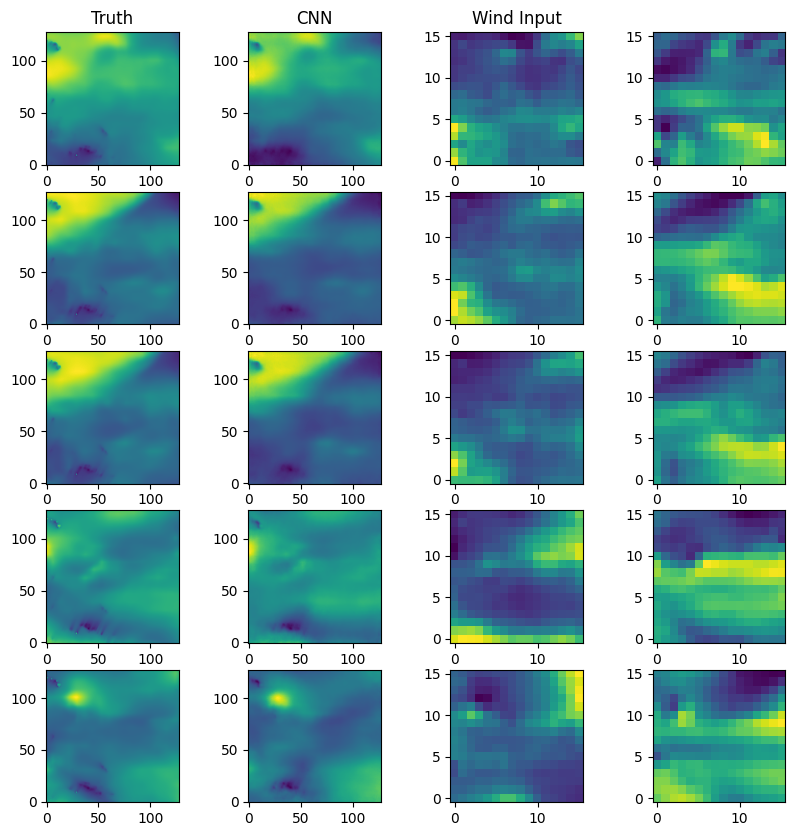

In [13]:
# random selection of truth, generated, and input images
num_row = 5
index = np.random.randint(0,hs_tens.size()[0], (num_row))
index = index.astype(int)

row = np.linspace(0,num_row-1, num_row)
row = row.astype(int)

fig, ax = plt.subplots(num_row, 4, figsize=(10, 10))
ax[0,0].set_title('Truth')
ax[0,1].set_title('CNN')
ax[0,2].set_title('Wind Input')


for i,j in zip(index,row):
    ax[j,0].imshow(hs_tens[i, 0, ...].detach().cpu(), origin="lower")
    ax[j,1].imshow(pred_tens[i, 0, ...].detach().cpu(), origin="lower")
    ax[j,2].imshow(w_tens[i, 0, ...].detach().cpu(), origin="lower")
    ax[j,3].imshow(w_tens[i, 1, ...].detach().cpu(), origin="lower")

Text(0.5, 1.0, 'CNN (6 residual blocks)')

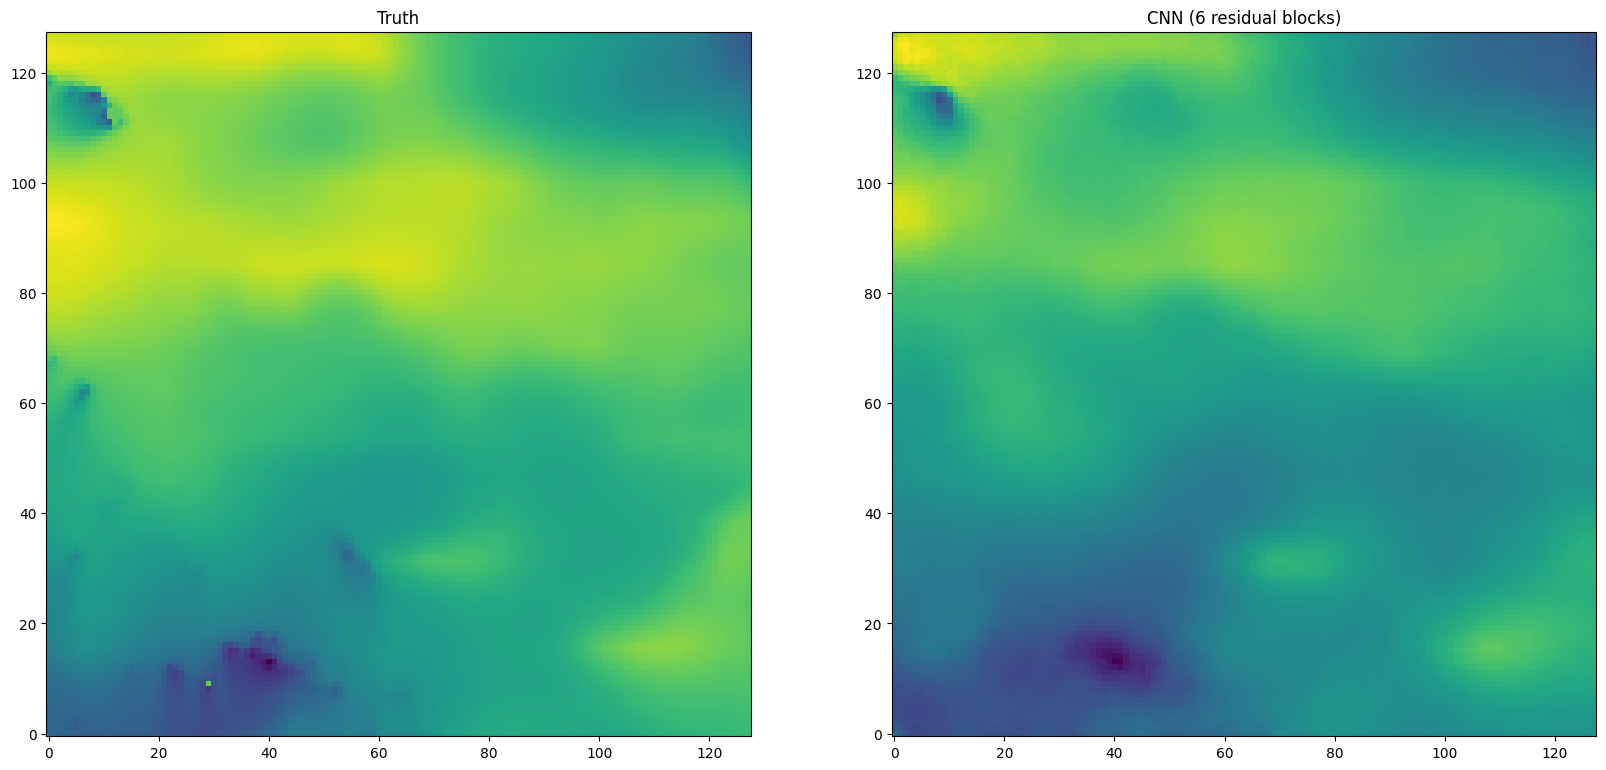

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
i = np.random.randint(0,hs_tens.size()[0])
ax[0].imshow(hs_tens[i, 0, ...].detach().cpu(), origin="lower")
ax[0].set_title('Truth')
ax[1].imshow(pred_tens[i, 0, ...].detach().cpu(), origin="lower")
ax[1].set_title("CNN (6 residual blocks)")

In [15]:
# code from RAPSD

from typing import Generator, Tuple

import numpy as np
import scipy.stats as stats


"""This module contains functions that calculate the
radially averaged power spectral density (RASPD)
"""


def calculate_2dft(image: np.ndarray) -> np.ndarray:
    """Computes the fourier transform and returns the amplitudes"""
    fourier_image = np.fft.fftn(image)
    # fourier_image = torch.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2
    # fourier_amplitudes = torch.abs(fourier_image)**2

    return fourier_amplitudes.flatten()


def define_wavenumers(hr_dim: int) -> np.ndarray:
    """Defines the wavenumbers for the RASPD"""
    kfreq = np.fft.fftfreq(hr_dim)*hr_dim
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    return knrm.flatten()


def get_mean_bins(x, var_idx, knrm) -> Tuple:
    """Calculates the mean bins for the RASPD"""
    kbins = np.arange(0.5, x.shape[-1]//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    wind_2d = calculate_2dft(x[var_idx, ...].cpu().detach().numpy())
    average_bins, _, _ = stats.binned_statistic(
        knrm, wind_2d, statistic="mean", bins=kbins
        )
    average_bins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return average_bins, kvals


def compute_rapsd(
        hr_field: Generator,
        var_ref: dict = None,
        reduce=True
) -> np.ndarray:
    """Computes the RASPD for a given super-resolution model"""

    if var_ref is None:
        var_ref = {"hs": 0}

    var_rapsd = {}
    [var_rapsd.setdefault(x, []) for x in var_ref]

    for x in hr_field:
        for var_name, var_idx in var_ref.items():
            knrm = define_wavenumers(x.shape[-1])
            average_bins, kvals = get_mean_bins(x, var_idx, knrm)
            var_rapsd[var_name].append(average_bins)

    var_rapsd_avg = {"k": kvals}
    for var_name in var_ref:
        if reduce:
            var_rapsd_avg[var_name] = np.mean(
                np.array(var_rapsd[var_name]),
                axis=0
            )
        else:
            var_rapsd_avg[var_name] = var_rapsd[var_name]

    return var_rapsd_avg


In [16]:
fake = compute_rapsd(pred_tens)
real = compute_rapsd(hs_tens)
fake_mean = np.mean(fake['hs'])
real_mean = np.mean(real['hs'])
norm_fake = fake['hs']/fake_mean
norm_real = real['hs']/real_mean


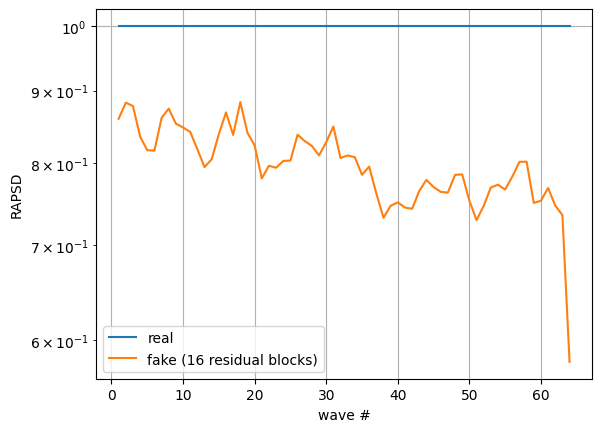

In [17]:
f,ax = plt.subplots()
# closer to horizontal line is better
# lack of power especially at small spatial scales
# bias???? lack of power 
# ax.plot(fake_6['k'], fake_6['hs']/real_6['hs'], label='fake (6 residual blocks)')
ax.plot(real['k'], real['hs']/real['hs'], label='real')
ax.plot(fake['k'], fake['hs']/real['hs'], label='fake (16 residual blocks)')
# ax.set_xscale('log')
ax.set_yscale('log')
plt.ylabel('RAPSD')
plt.xlabel('wave #')
ax.legend()
ax.grid()

In [18]:
import torch.nn.functional as F

mse = F.mse_loss(pred_tens, hs_tens)
mae = F.l1_loss(pred_tens, hs_tens)
print('mse: ', mse, 'mae: ', mae)

mse:  tensor(0.0990) mae:  tensor(0.2337)


Compare points and map the std and means and compare to truth 

99th percentile

Pick a point and map scatter plot of wind and hs -> see what type of relationship data has 

See how wave height prediction vs truth compare for one location

make maps of metrics to see where the differences are

In [19]:
hs_tens[1, 0 , ...].size()
# hs_tens[time, var, lat, lon]
torch.max(hs_tens[1,...]).values
#torch.max(hs_tens[1])

<function Tensor.values>

Max predicted vs max hs

Predicted vs hs

99th percentile 

Max 

Mean

Std 

At all lat and lon and then also at specific ones 

Guess ill just redo all that later then 


### metrics per time and all lat/lon

In [20]:
max_hs_tot = []
max_pred_tot = []
hs_99th_tot = []
pred_99th_tot = []
mean_hs_tot = []
mean_pred_tot = []
std_hs_tot = []
std_pred_tot = []
for i in range(0, len(hs_tens)):
    max_hs_tot.append(torch.max(hs_tens[i, ...]))
    max_pred_tot.append(torch.max(pred_tens[i, ...]))
    hs_99th_tot.append(torch.quantile(hs_tens[i,...],0.99))
    pred_99th_tot.append(torch.quantile(pred_tens[i,...],0.99))
    mean_hs_tot.append(torch.mean(hs_tens[i,...]))
    mean_pred_tot.append(torch.mean(pred_tens[i,...]))
    std_hs_tot.append(torch.std(hs_tens[i,...]))
    std_pred_tot.append(torch.std(pred_tens[i,...]))

In [44]:
(hs_tens.size()[0])

(max_hs_tot).shape()

AttributeError: 'list' object has no attribute 'shape'

ValueError: x and y must have same first dimension, but have shapes (1,) and (433,)

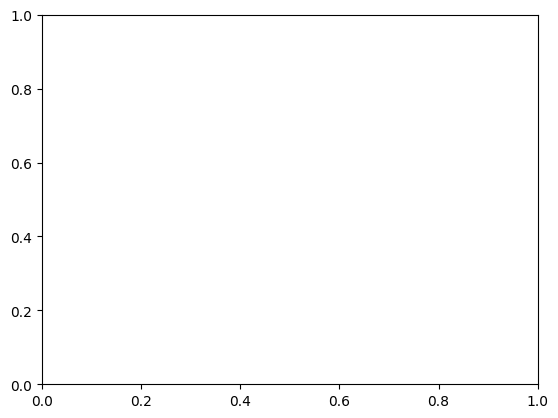

In [41]:
f,ax = plt.subplots()
ax.plot(len(max_hs_tot), max_hs_tot)

ax.grid()

In [25]:
j = np.random.randint(0,hs_tens.size()[2], size=2)
lat = j[0]
lon = j[1]